# Install missing libraries

In [ ]:
!pip install river
!pip install numpy==1.24.3

Need to restart the runtime

# Connect to Drive

In [ ]:
# Connect to Drive
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/SDA project/

# Import libraries

In [137]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

from river import drift
from river.metrics import Accuracy,BalancedAccuracy,CohenKappa,GeometricMean
from river.metrics.base import Metrics
from river.utils import Rolling
from river.evaluate import progressive_val_score
from river.tree import HoeffdingAdaptiveTreeClassifier
from river.forest import ARFClassifier
from river.stream import iter_sklearn_dataset, iter_pandas
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import binary_crossentropy
tfk = tf.keras
tfkl = tf.keras.layers

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

# Data loading

In [8]:
X_paths = [
    './fan/id_00/X.npy',
    './fan/id_02/X.npy',
    './fan/id_04/X.npy',
    './fan/id_06/X.npy'
]

y_paths = [
    './fan/id_00/y.npy',
    './fan/id_02/y.npy',
    './fan/id_04/y.npy',
    './fan/id_06/y.npy'
]

num_experiences = len(X_paths)

In [9]:
# Load experiences
X_data = dict()
y_data = dict()
for i in range(num_experiences):
    X_data[i] = np.load(X_paths[i])
    y_data[i] = np.load(y_paths[i])[:,0]  # take only the first column

# Data pre-processing

### Labels distribution

In [ ]:
# Compute the percentage of labels in each experience
def compute_percentages(num_exp, value_to_count, y_data):  # y_data is a dict containing arrays of labels for each experience
  percentages = dict()
  percentages[0] = np.empty(num_exp)

  for i,arr in enumerate(y_data.values()):
      count = np.array(np.sum(arr == value_to_count))
      percentages[0][i] = count / len(arr) * 100

  percentages[1] = 100 - percentages[0]
  return percentages


# Plot labels distribution
def plot_label_distribution(percentage1, percentage2, num_exp, labels):
    x_labels = [f"Exp{i}" for i in range(1, num_exp+1)]
    x = np.arange(len(x_labels))
    width = 0.4

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_ylim(0,100)
    ax.bar(x-width/2, percentage1, width, label=labels[0])
    ax.bar(x+width/2, percentage2, width, label=labels[1])
    ax.set_xlabel('Experiences')
    ax.set_ylabel('Percentage')
    ax.set_title('Labels distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    plt.yticks(np.arange(0, 110, 10))
    plt.show()

			 Experience1 Experience2 Experience3 Experience4

Percentage of Label 1:  [28.70239774 26.10909091 25.19913106 26.23546512]
Percentage of Label 2:  [71.29760226 73.89090909 74.80086894 73.76453488]


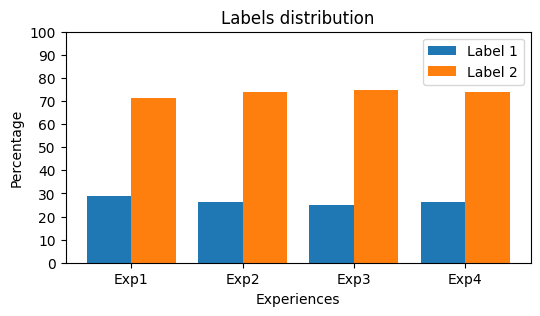

In [ ]:
# Percentages
percentages = compute_percentages(num_experiences, 1, y_data)
percentage1, percentage2 = percentages[0], percentages[1]
print("\t\t\t Experience1 Experience2 Experience3 Experience4\n")
print("Percentage of Label 1: ", percentage1)
print("Percentage of Label 2: ", percentage2)

# Plot
plot_label_distribution(percentage1, percentage2, num_exp=num_experiences, labels=['Label 1', 'Label 2'])

### Undersampling
We want to reduce the number of samples in the majority class (label 2 in this case), so that the final ratio is 60-40.

In [ ]:
# Use RandomUnderSampler from imblearn library
X_resampled = dict()
y_resampled = dict()

desired_majority_ratio = 0.6
desired_minority_ratio = 0.4

for i in range(num_experiences):
    # Number of samples in the minority class - not changed
    num_minority_samples = np.sum(y_data[i] == 1)
    # Calculate the number of samples to keep for the majority class
    num_majority_samples = int(num_minority_samples / desired_minority_ratio * desired_majority_ratio)
    # Random undersampling of the majority class
    rus = RandomUnderSampler(sampling_strategy={2: num_majority_samples}, random_state=42)
    X_resampled[i], y_resampled[i] = rus.fit_resample(X_data[i], y_data[i])


### New labels distribution

			 Experience1 Experience2 Experience3 Experience4

Percentage of Label 1:  [40.00218412 40.00247617 40.         40.00246245]
Percentage of Label 2:  [59.99781588 59.99752383 60.         59.99753755]


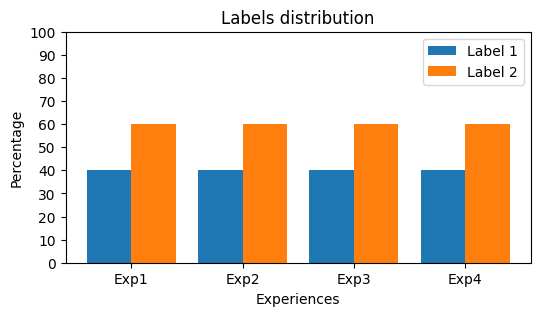

In [ ]:
# Percentages
percentages = compute_percentages(num_experiences, 1, y_resampled)
percentage1, percentage2 = percentages[0], percentages[1]
print("\t\t\t Experience1 Experience2 Experience3 Experience4\n")
print("Percentage of Label 1: ", percentage1)
print("Percentage of Label 2: ", percentage2)

# Plot
plot_label_distribution(percentage1, percentage2, num_exp=num_experiences, labels=['Label 1', 'Label 2'])

### Split train-test

In [ ]:
# Split train set and test set for each experience, starting from the resampled dataset
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for i in range(num_experiences):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X_resampled[i], y_resampled[i], test_size=0.2, random_state=42, stratify=y_resampled[i])


In [ ]:
# Clean memory
del X_data, y_data, X_resampled, y_resampled
del X_paths, y_paths, rus, percentages
del desired_minority_ratio, desired_majority_ratio, num_majority_samples, num_minority_samples

### Feature extraction

In [ ]:
# Load model
transfer_model = tfk.models.load_model('model.h5')

CUT = 'flatten'  # choose at which layer to cut the neural network

print(transfer_model.summary())
print()
if CUT == 'flatten':  # output shape 800
    new_model = tf.keras.models.Sequential(transfer_model.layers[:-3])
else:  # CUT == 'dense'  output shape 20
    new_model = tf.keras.models.Sequential(transfer_model.layers[:-2])
print(new_model.summary())


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 199, 65)           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 199, 8)            1568      
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 100, 8)            0         
 ng1D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 100, 8)            0         
                                                                 
 conv1d_25 (Conv1D)          (None, 100, 16)           400       
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 50, 16)            0         
 ng1D)                                               

In [ ]:
for i in range(num_experiences):
  X_train[i] = new_model.predict(X_train[i])
  X_test[i] = new_model.predict(X_test[i])

51/51 [==============================] - 0s 4ms/step


### Final dataset

In [ ]:
# Target must be 0/1
for i in range(num_experiences):
  y_train[i] -= 1
  y_test[i] -= 1

In [ ]:
# Save final dataset
"""for i in range(num_experiences):
  np.save('final_dataset/X_train' + str(i) + '.npy', X_train[i])
  np.save('final_dataset/y_train' + str(i) + '.npy', y_train[i])
  np.save('final_dataset/X_test' + str(i) + '.npy', X_test[i])
  np.save('final_dataset/y_test' + str(i) + '.npy', y_test[i])
"""

# SML models

In [93]:
num_experiences = 4

# Load final dataset
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()
for i in range(num_experiences):
  X_train[i] = np.load('final_dataset/X_train' + str(i) + '.npy', allow_pickle=True)
  print('X_train['+str(i)+']:\t' + str(X_train[i].shape))
  y_train[i] = np.load('final_dataset/y_train' + str(i) + '.npy', allow_pickle=True)
  print('y_train['+str(i)+']:\t' + str(y_train[i].shape))
  X_test[i] = np.load('final_dataset/X_test' + str(i) + '.npy', allow_pickle=True)
  print('X_test['+str(i)+']:\t' + str(X_test[i].shape))
  y_test[i] = np.load('final_dataset/y_test' + str(i) + '.npy', allow_pickle=True)
  print('y_test['+str(i)+']:\t' + str(y_test[i].shape))

X_train[0]:	(7325, 800)
y_train[0]:	(7325,)
X_test[0]:	(1832, 800)
y_test[0]:	(1832,)
X_train[1]:	(6461, 800)
y_train[1]:	(6461,)
X_test[1]:	(1616, 800)
y_test[1]:	(1616,)
X_train[2]:	(6264, 800)
y_train[2]:	(6264,)
X_test[2]:	(1566, 800)
y_test[2]:	(1566,)
X_train[3]:	(6497, 800)
y_train[3]:	(6497,)
X_test[3]:	(1625, 800)
y_test[3]:	(1625,)


## Utility functions

In [95]:
# Train function for SML models
def SML_train(model, X_train, y_train): # X_train and y_train are Numpy arrays
  for j, (xi, yi) in enumerate(zip(X_train, y_train)):
    # Create a dictionary of features with keys as indices and values as array elements
    x = {i: xi[i] for i in range(xi.shape[0])}
    model.learn_one(x=x, y=yi)              # Train the model
    if j%1000 == 0: print(j)                # Check progress


# Test function for SML models
def SML_test(model, X_test):
  y_pred = []
  for xi in X_test:
    x = {i: xi[i] for i in range(xi.shape[0])}
    y_pred.append(model.predict_one(x=x))   # Predict class-label
  return y_pred


# Plot performances
def plot_performances(title, accuracy):
    x_labels = [f"Train e{i}" for i in range(1, len(accuracy)+1)]
    x = np.arange(len(x_labels))
    width = 0.2
    # Create a matrix from the accuracy dict:
    # i-th row includes the values obtained after testing the model trained on the i-th experience
    acc_matrix = np.array([accuracy[key] for key in sorted(accuracy.keys())])

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_ylim(0,1)
    ax.bar(x - (3/2)*width, acc_matrix[:, 0], width, label='Test e1')
    ax.bar(x - (1/2)*width, acc_matrix[:, 1], width, label='Test e2')
    ax.bar(x + (1/2)*width, acc_matrix[:, 2], width, label='Test e3')
    ax.bar(x + (3/2)*width, acc_matrix[:, 3], width, label='Test e4')
    ax.set_xlabel('Experiences')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    ax.legend()
    plt.legend(loc='upper left', ncol=2)

    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.show()

In [96]:
# Average accuracy
def average_accuracy(accuracy, num_exp):
  avg = 0
  for i in range(num_exp):
    avg += accuracy[num_exp-1][i]
  avg /= num_exp
  return avg

# A metric
def a_metric(accuracy, num_exp):
  a = 0
  for i in range(num_exp):
    for j in range(i+1):
      a += accuracy[i][j]
  a /= (num_exp * (num_exp + 1) / 2)
  return a

# Forward transfer metric
def ft_metric(accuracy, accuracy_random, num_exp):
  ft = 0
  for i in range(1,num_exp):
    ft += (accuracy[i-1][i] - accuracy_random[i])
  ft /= (num_exp-1)
  return float(ft[0])

# Backward transfer metric
def bt_metric(accuracy, num_exp):
  bt = 0
  for i in range(0,num_exp-1):
    bt += (accuracy[num_exp-1][i] - accuracy[i][i])
  bt /= (num_exp-1)
  return bt

## Adaptive Random Forest

It's not possible to test the ARFClassifier and HoeffdingAdaptiveTreeClassifier without training them first. Therefore, I used random vectors to simulate random predictions, aiming to compute the forward transfer metric later.

In [97]:
# Accuracy of random model
ARF_random_accuracy = {i: [] for i in range(num_experiences)}
np.random.seed(42)

for i in range (num_experiences):
  y_pred = []
  y_pred = np.random.randint(2, size=len(y_test[i]))   # simulate predictions
  ARF_random_accuracy[i].append(accuracy_score(y_test[i], y_pred))

ARF_random_accuracy

{0: [0.5218340611353712],
 1: [0.5148514851485149],
 2: [0.49106002554278416],
 3: [0.4849230769230769]}

Since it is a binary classification problem, I think it's reasonable to expect that a random model would give the correct answer around 50% of the time.

In [98]:
# Define the model adding a drift detector
ARF_model = ARFClassifier(n_models=5, drift_detector=drift.ADWIN(delta=0.001), warning_detector=drift.ADWIN(delta=0.01), seed=42)

ARF_accuracy = {i: [] for i in range(num_experiences)}

Train the model and compute the values in the following table.
\
<b>R<sub>i,j</sub></b>: Accuracy computed after training on the i-th experience and testing on the j-th experience

\

|         | <font size="4">Test e<sub>1</sub></font> | <font size="4">Test e<sub>2</sub></font> | <font size="4">Test e<sub>3</sub></font> | <font size="4">Test e<sub>4</sub></font> |
|---------|-------------------------------------|-------------------------------------|-------------------------------------|-------------------------------------|
| <b><font size="4">Train e<sub>1</sub></font></b> | <font size="4">R<sub>1,1</sub></font> | <font size="4">R<sub>1,2</sub></font> | <font size="4">R<sub>1,3</sub></font> | <font size="4">R<sub>1,4</sub></font> |
| <b><font size="4">Train e<sub>2</sub></font></b> | <font size="4">R<sub>2,1</sub></font> | <font size="4">R<sub>2,2</sub></font> | <font size="4">R<sub>2,3</sub></font> | <font size="4">R<sub>2,4</sub></font> |
| <b><font size="4">Train e<sub>3</sub></font></b> | <font size="4">R<sub>3,1</sub></font> | <font size="4">R<sub>3,2</sub></font> | <font size="4">R<sub>3,3</sub></font> | <font size="4">R<sub>3,4</sub></font> |
| <b><font size="4">Train e<sub>4</sub></font></b> | <font size="4">R<sub>4,1</sub></font> | <font size="4">R<sub>4,2</sub></font> | <font size="4">R<sub>4,3</sub></font> | <font size="4">R<sub>4,4</sub></font> |


\
The model is trained one sample at a time, from the
first experience to the last one, and after each experience we compute its accuracy on the test sets of all experiences.







In [99]:
# Train the model one experience after the other
for i in range(num_experiences):
  print("Start training on experience " + str(i+1))
  SML_train(ARF_model, X_train[i], y_train[i])
  print("End training on experience " + str(i+1))

  # Compute the accuracy of the i-th model wrt the experience j
  print("Computing accuracy values on all test sets..")
  for j in range(num_experiences):
    y_pred = SML_test(ARF_model, X_test[j])
    ARF_accuracy[i].insert(j, accuracy_score(y_test[j], y_pred))
    print("\tAccuracy R("+str(i+1)+","+str(j+1)+"): ", ARF_accuracy[i][j])
  print()

Start training on experience 1
0
1000
2000
3000
4000
5000
6000
7000
End training on experience 1
Computing accuracy values on all test sets..
	Accuracy R(1,1):  0.7096069868995634
	Accuracy R(1,2):  0.2667079207920792
	Accuracy R(1,3):  0.38569604086845466
	Accuracy R(1,4):  0.19507692307692306

Start training on experience 2
0
1000
2000
3000
4000
5000
6000
End training on experience 2
Computing accuracy values on all test sets..
	Accuracy R(2,1):  0.31277292576419213
	Accuracy R(2,2):  0.7326732673267327
	Accuracy R(2,3):  0.6174968071519795
	Accuracy R(2,4):  0.7581538461538462

Start training on experience 3
0
1000
2000
3000
4000
5000
6000
End training on experience 3
Computing accuracy values on all test sets..
	Accuracy R(3,1):  0.6048034934497817
	Accuracy R(3,2):  0.5284653465346535
	Accuracy R(3,3):  0.6590038314176245
	Accuracy R(3,4):  0.6209230769230769

Start training on experience 4
0
1000
2000
3000
4000
5000
6000
End training on experience 4
Computing accuracy values on a

### Plot performances

Train e1:  [0.7096069868995634, 0.2667079207920792, 0.38569604086845466, 0.19507692307692306]
Train e2:  [0.31277292576419213, 0.7326732673267327, 0.6174968071519795, 0.7581538461538462]
Train e3:  [0.6048034934497817, 0.5284653465346535, 0.6590038314176245, 0.6209230769230769]
Train e4:  [0.40556768558951967, 0.5445544554455446, 0.6245210727969349, 0.9778461538461538]



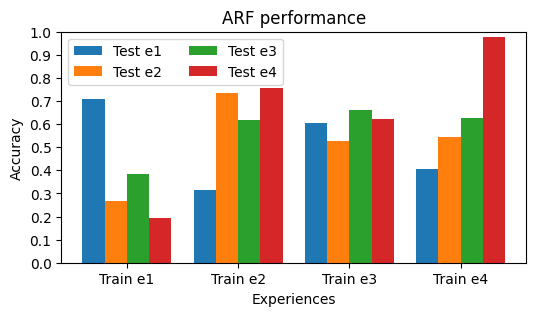

In [100]:
for i in range(num_experiences):
  print("Train e"+str(i+1)+': ', ARF_accuracy[i])
print()
plot_performances('ARF performance', ARF_accuracy)

The model exhibits **plasticity** as it can continuously learn and adapt to subsequent experiences, but it lacks stability as the performance on previously learned experiences is reduced, especially in the first one.

### Metrics

In [101]:
# Average accuracy
ARF_avg_accuracy = average_accuracy(ARF_accuracy, num_experiences)

# A metric
ARF_a_metric = a_metric(ARF_accuracy, num_experiences)

# Forward transfer metric
ARF_ft_metric = ft_metric(ARF_accuracy, ARF_random_accuracy, num_experiences)

# Backward transfer metric
ARF_bt_metric = bt_metric(ARF_accuracy, num_experiences)

In [102]:
print('Average accuracy: ', ARF_avg_accuracy)
print('A metric: ', ARF_a_metric)
print('Forward transfer metric: ', ARF_ft_metric)
print('Backward transfer metric: ', ARF_bt_metric)

Average accuracy:  0.6381223419195383
A metric:  0.6099815219070702
Forward transfer metric:  0.004764405750919909
Backward transfer metric:  -0.17554695727064043


A negative value of **backward transfer** indicates forgetting, a point that is clearly evident from the plot. On the other hand, when considering the **forward transfer** property, the plot shows that during the third training, the fourth experience does not exhibit an improvement in performance. However, when we also consider the forward transfer metric, the model does show a slight ability to enhance its performance on future experiences (wrt a random model). Nevertheless, since the value is quite small, it may vary depending on the training or the performance of the random model and even become negative. In conclusion, I would not consider it a valid property of the model.

## Hoeffding Adaptive Tree

In [103]:
# Accuracy of random model
HAT_random_accuracy = {i: [] for i in range(num_experiences)}
np.random.seed(3)

for i in range (num_experiences):
  y_pred = []
  y_pred = np.random.randint(2, size=len(y_test[i]))   # simulate predictions
  HAT_random_accuracy[i].append(accuracy_score(y_test[i], y_pred))

HAT_random_accuracy

{0: [0.49890829694323147],
 1: [0.4969059405940594],
 2: [0.5063856960408685],
 3: [0.5138461538461538]}

In [104]:
# Define the model
HAT_model = HoeffdingAdaptiveTreeClassifier(seed=42)

HAT_accuracy = {i: [] for i in range(num_experiences)}

In [105]:
# Train the model one experience after the other
for i in range(num_experiences):
  print("Start training on experience " + str(i+1))
  SML_train(HAT_model, X_train[i], y_train[i])
  print("End training on experience " + str(i+1))

  # Compute the accuracy of the i-th model wrt the experience j
  print("Computing accuracy values on all test sets..")
  for j in range(num_experiences):
    y_pred = SML_test(HAT_model, X_test[j])
    HAT_accuracy[i].insert(j, accuracy_score(y_test[j], y_pred))
    print("\tAccuracy R("+str(i+1)+","+str(j+1)+"): ", HAT_accuracy[i][j])
  print()

Start training on experience 1
0
1000
2000
3000
4000
5000
6000
7000
End training on experience 1
Computing accuracy values on all test sets..
	Accuracy R(1,1):  0.6719432314410481
	Accuracy R(1,2):  0.275990099009901
	Accuracy R(1,3):  0.36909323116219667
	Accuracy R(1,4):  0.2443076923076923

Start training on experience 2
0
1000
2000
3000
4000
5000
6000
End training on experience 2
Computing accuracy values on all test sets..
	Accuracy R(2,1):  0.3564410480349345
	Accuracy R(2,2):  0.7128712871287128
	Accuracy R(2,3):  0.49744572158365263
	Accuracy R(2,4):  0.4590769230769231

Start training on experience 3
0
1000
2000
3000
4000
5000
6000
End training on experience 3
Computing accuracy values on all test sets..
	Accuracy R(3,1):  0.6009825327510917
	Accuracy R(3,2):  0.37995049504950495
	Accuracy R(3,3):  0.6500638569604087
	Accuracy R(3,4):  0.664

Start training on experience 4
0
1000
2000
3000
4000
5000
6000
End training on experience 4
Computing accuracy values on all test sets..

### Plot performances

Train e1:  [0.6719432314410481, 0.275990099009901, 0.36909323116219667, 0.2443076923076923]
Train e2:  [0.3564410480349345, 0.7128712871287128, 0.49744572158365263, 0.4590769230769231]
Train e3:  [0.6009825327510917, 0.37995049504950495, 0.6500638569604087, 0.664]
Train e4:  [0.4705240174672489, 0.41398514851485146, 0.5747126436781609, 0.9384615384615385]



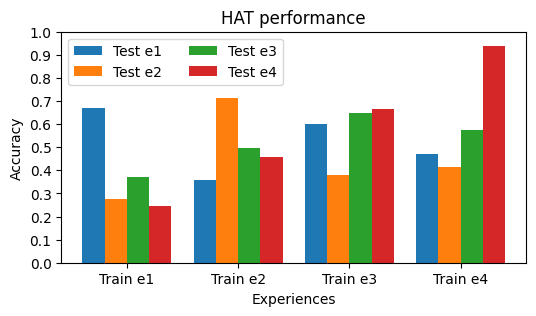

In [106]:
for i in range(num_experiences):
  print("Train e"+str(i+1)+': ', HAT_accuracy[i])
print()
plot_performances('HAT performance', HAT_accuracy)

The model exhibits **plasticity** as it can continuously learn and adapt to subsequent experiences, but it lacks stability as the performance on previously learned experiences is reduced.

### Metrics

In [107]:
# Average accuracy
HAT_avg_accuracy = average_accuracy(HAT_accuracy, num_experiences)

# A metric
HAT_a_metric = a_metric(HAT_accuracy, num_experiences)

# Forward transfer metric
HAT_ft_metric = ft_metric(HAT_accuracy, HAT_random_accuracy, num_experiences)

# Backward transfer metric
HAT_bt_metric = bt_metric(HAT_accuracy, num_experiences)

In [109]:
print('Average accuracy: ', HAT_avg_accuracy)
print('A metric: ', HAT_a_metric)
print('Forward transfer metric: ', HAT_ft_metric)
print('Backward transfer metric: ', HAT_bt_metric)

Average accuracy:  0.5994208370304499
A metric:  0.57699357994875
Forward transfer metric:  -0.026567323295842677
Backward transfer metric:  -0.1918855219566361


No **backward transfer** property is observed. In the case of the **forward transfer** property, the situation is the exact opposite compared to the previous model. From the plot, it might seem that the model possesses this property; however, the ft metric indicates the opposite. Since also in this case the value is very small, I would not consider this a strong property of the model.

## SML models (2nd case)

The SML models, for each task, can use the entire experience to learn continuously (including both training and test sets). For the performance evaluation, after each experience's training, you must evaluate the performance on the current test set
using the prequential evaluation: on each data point of the test set, first test and then train. Then, you must only perform the test phase without training on the other experiences. Please be aware that, in this case, we are using the test set of the previous experiences on which we have previously trained the model. Despite this, it could still be helpful to analyze the stability of the SML models.

In [110]:
# from Numpy array to Dataframe
data = dict()
for i in range(num_experiences):
  data[i] = pd.DataFrame(data=X_test[i])
  data[i]['target'] = pd.DataFrame(data=y_test[i])

#data

### Adaptive Random Forest

In [111]:
# Accuracy of random model
ARF2_random_accuracy = {i: [] for i in range(num_experiences)}
np.random.seed(42)

for i in range (num_experiences):
  y_pred = []
  y_pred = np.random.randint(2, size=len(y_test[i]))   # simulate predictions
  ARF2_random_accuracy[i].append(accuracy_score(y_test[i], y_pred))

ARF2_random_accuracy

{0: [0.5218340611353712],
 1: [0.5148514851485149],
 2: [0.49106002554278416],
 3: [0.4849230769230769]}

In [112]:
# Define the model adding a drift detector
ARF2_model = ARFClassifier(n_models=5, drift_detector=drift.ADWIN(delta=0.001), warning_detector=drift.ADWIN(delta=0.01), seed=42)

ARF2_accuracy = {i: [] for i in range(num_experiences)}

In [113]:
# Train the model one experience after the other and do prequential evaluation on test set of current experience
for i in range(num_experiences):
  print("Start training on experience " + str(i+1))
  SML_train(ARF2_model, X_train[i], y_train[i])

  print("Prequential evaluation on current experience test set..")
  # Create stream from i-th test set
  stream = iter_pandas(X=data[i].iloc[:, :-1], y=data[i]['target'])
  metric = Accuracy()
  progressive_val_score(dataset=stream,
                      model=ARF2_model,
                      metric=metric,
                      print_every=500)

  # Store accuracy R(i,i) obtained from prequential evaluation
  ARF2_accuracy[i].insert(i, metric.get())
  print("\tAccuracy R("+str(i+1)+","+str(i+1)+"): ", ARF2_accuracy[i][0])
  print("End training on experience " + str(i+1) + "\n")

  # Compute the accuracy of the i-th model wrt the experience j!=i
  print("Computing accuracy values on other test sets..")
  for j in range(num_experiences):
    if j != i:
      y_pred = SML_test(ARF2_model, X_test[j])
      ARF2_accuracy[i].insert(j, accuracy_score(y_test[j], y_pred))
      print("\tAccuracy R("+str(i+1)+","+str(j+1)+"): ", ARF2_accuracy[i][j])
  print()


Start training on experience 1
0
1000
2000
3000
4000
5000
6000
7000
Prequential evaluation on current experience test set..
[500] Accuracy: 72.00%
[1,000] Accuracy: 71.70%
[1,500] Accuracy: 72.07%
[1,832] Accuracy: 71.67%
	Accuracy R(1,1):  0.7167030567685589
End training on experience 1

Computing accuracy values on other test sets..
	Accuracy R(1,2):  0.26732673267326734
	Accuracy R(1,3):  0.3837803320561941
	Accuracy R(1,4):  0.19815384615384615

Start training on experience 2
0
1000
2000
3000
4000
5000
6000
Prequential evaluation on current experience test set..
[500] Accuracy: 69.40%
[1,000] Accuracy: 70.90%
[1,500] Accuracy: 71.47%
[1,616] Accuracy: 72.34%
	Accuracy R(2,2):  0.7233910891089109
End training on experience 2

Computing accuracy values on other test sets..
	Accuracy R(2,1):  0.29366812227074235
	Accuracy R(2,3):  0.6040868454661558
	Accuracy R(2,4):  0.7753846153846153

Start training on experience 3
0
1000
2000
3000
4000
5000
6000
Prequential evaluation on current e

#### Plot performances

Train e1:  [0.7167030567685589, 0.26732673267326734, 0.3837803320561941, 0.19815384615384615]
Train e2:  [0.29366812227074235, 0.7233910891089109, 0.6040868454661558, 0.7753846153846153]
Train e3:  [0.6124454148471615, 0.5383663366336634, 0.6673052362707536, 0.6615384615384615]
Train e4:  [0.40829694323144106, 0.5532178217821783, 0.6385696040868455, 0.9753846153846154]



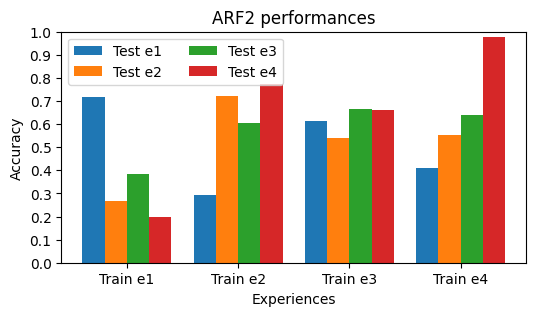

In [114]:
for i in range(num_experiences):
  print("Train e"+str(i+1)+': ', ARF2_accuracy[i])
print()
plot_performances('ARF2 performances', ARF2_accuracy)

#### Metrics

In [115]:
# Average accuracy
ARF2_avg_accuracy = average_accuracy(ARF2_accuracy, num_experiences)

# A metric
ARF2_a_metric = a_metric(ARF2_accuracy, num_experiences)

# Forward transfer metric
ARF2_ft_metric = ft_metric(ARF2_accuracy, ARF2_random_accuracy, num_experiences)

# Backward transfer metric
ARF2_bt_metric = bt_metric(ARF2_accuracy, num_experiences)

In [116]:
print('Average accuracy: ', ARF2_avg_accuracy)
print('A metric: ', ARF2_a_metric)
print('Forward transfer metric: ', ARF2_ft_metric)
print('Backward transfer metric: ', ARF2_bt_metric)

Average accuracy:  0.64386724612127
A metric:  0.6127348240384871
Forward transfer metric:  0.014039150687836233
Backward transfer metric:  -0.16910500434925288


### Hoeffding Adaptive Tree

In [117]:
# Accuracy of random model
HAT2_random_accuracy = {i: [] for i in range(num_experiences)}
np.random.seed(3)

for i in range (num_experiences):
  y_pred = []
  y_pred = np.random.randint(2, size=len(y_test[i]))   # simulate predictions
  HAT2_random_accuracy[i].append(accuracy_score(y_test[i], y_pred))

HAT2_random_accuracy

{0: [0.49890829694323147],
 1: [0.4969059405940594],
 2: [0.5063856960408685],
 3: [0.5138461538461538]}

In [118]:
# Define the model
HAT2_model = HoeffdingAdaptiveTreeClassifier(seed=42)

HAT2_accuracy = {i: [] for i in range(num_experiences)}

In [119]:
# Train the model one experience after the other and do prequential evaluation on test set of current experience
for i in range(num_experiences):
  print("Start training on experience " + str(i+1))
  SML_train(HAT2_model, X_train[i], y_train[i])

  print("Prequential evaluation on current experience test set..")
  # Create stream from i-th test set
  stream = iter_pandas(X=data[i].iloc[:, :-1], y=data[i]['target'])
  metric = Accuracy()
  progressive_val_score(dataset=stream,
                      model=HAT2_model,
                      metric=metric,
                      print_every=500)

  # Store accuracy R(i,i) obtained from prequential eval
  HAT2_accuracy[i].insert(i, metric.get())
  print("\tAccuracy R("+str(i+1)+","+str(i+1)+"): ", HAT2_accuracy[i][0])
  print("End training on experience " + str(i+1) + "\n")

  # Compute the accuracy of the i-th model wrt the experience j!=i
  print("Computing accuracy values on other test sets..")
  for j in range(num_experiences):
    if j != i:
      y_pred = SML_test(HAT2_model, X_test[j])
      HAT2_accuracy[i].insert(j, accuracy_score(y_test[j], y_pred))
      print("\tAccuracy R("+str(i+1)+","+str(j+1)+"): ", HAT2_accuracy[i][j])
  print()


Start training on experience 1
0
1000
2000
3000
4000
5000
6000
7000
Prequential evaluation on current experience test set..
[500] Accuracy: 69.80%
[1,000] Accuracy: 66.90%
[1,500] Accuracy: 67.20%
[1,832] Accuracy: 66.70%
	Accuracy R(1,1):  0.6670305676855895
End training on experience 1

Computing accuracy values on other test sets..
	Accuracy R(1,2):  0.2790841584158416
	Accuracy R(1,3):  0.36462324393358875
	Accuracy R(1,4):  0.22953846153846155

Start training on experience 2
0
1000
2000
3000
4000
5000
6000
Prequential evaluation on current experience test set..
[500] Accuracy: 70.20%
[1,000] Accuracy: 69.40%
[1,500] Accuracy: 70.33%
[1,616] Accuracy: 70.85%
	Accuracy R(2,2):  0.7085396039603961
End training on experience 2

Computing accuracy values on other test sets..
	Accuracy R(2,1):  0.3597161572052402
	Accuracy R(2,3):  0.5280970625798213
	Accuracy R(2,4):  0.5076923076923077

Start training on experience 3
0
1000
2000
3000
4000
5000
6000
Prequential evaluation on current ex

#### Plot performances

Train e1:  [0.6670305676855895, 0.2790841584158416, 0.36462324393358875, 0.22953846153846155]
Train e2:  [0.3597161572052402, 0.7085396039603961, 0.5280970625798213, 0.5076923076923077]
Train e3:  [0.5987991266375546, 0.48824257425742573, 0.6845466155810983, 0.6209230769230769]
Train e4:  [0.615174672489083, 0.400990099009901, 0.5727969348659003, 0.9027692307692308]



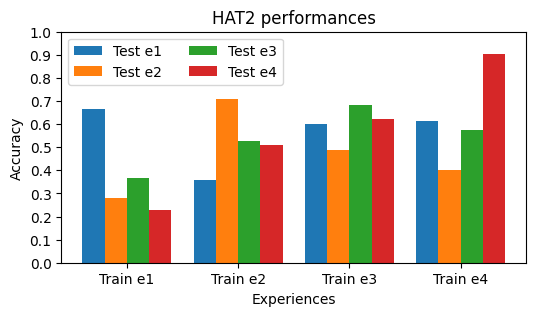

In [120]:
for i in range(num_experiences):
  print("Train e"+str(i+1)+': ', HAT2_accuracy[i])
print()
plot_performances('HAT2 performances', HAT2_accuracy)

#### Metrics

In [121]:
# Average accuracy
HAT2_avg_accuracy = average_accuracy(HAT2_accuracy, num_experiences)

# A metric
HAT2_a_metric = a_metric(HAT2_accuracy, num_experiences)

# Forward transfer metric
HAT2_ft_metric = ft_metric(HAT2_accuracy, HAT2_random_accuracy, num_experiences)

# Backward transfer metric
HAT2_bt_metric = bt_metric(HAT2_accuracy, num_experiences)

In [122]:
print('Average accuracy: ', HAT2_avg_accuracy)
print('A metric: ', HAT2_a_metric)
print('Forward transfer metric: ', HAT2_ft_metric)
print('Backward transfer metric: ', HAT2_bt_metric)

Average accuracy:  0.6229327342835288
A metric:  0.5998605582461419
Forward transfer metric:  -0.02967783085411398
Backward transfer metric:  -0.1570516936207332


## Comparison and comments

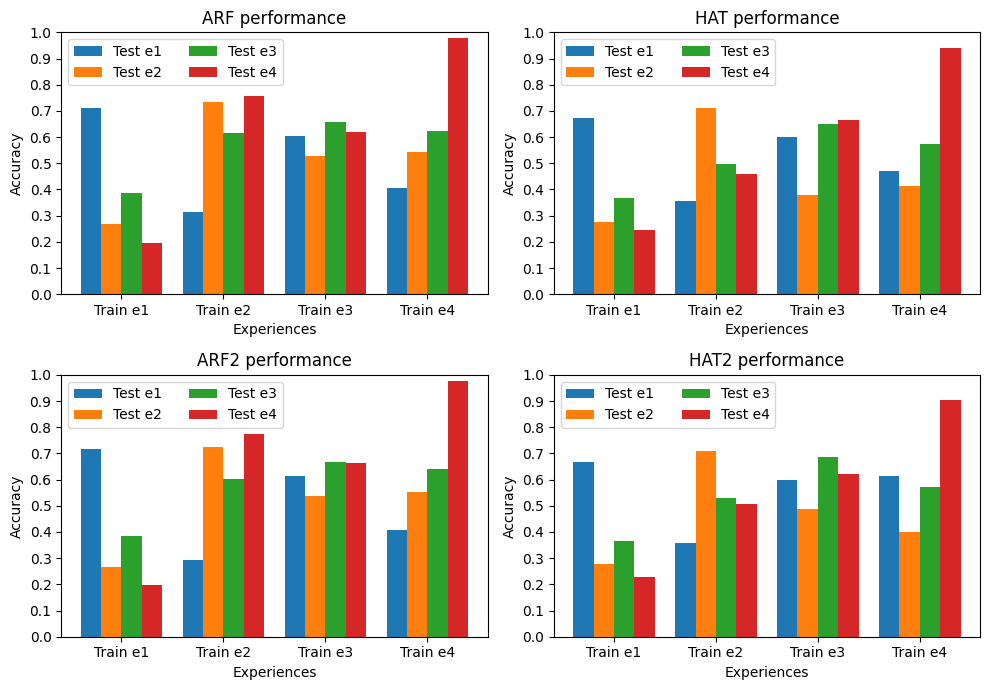

In [123]:
def comparison_plot(titles, accuracies_list, num_rows=2, num_cols=2):
  num_models = len(accuracies_list)
  num_experiences = max(len(acc) for acc in accuracies_list)

  x_labels = [f"Train e{i}" for i in range(1, num_experiences + 1)]
  x = np.arange(len(x_labels))
  width = 0.2

  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows - 1))

  for i in range(num_models):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    acc_matrix = np.array([accuracies_list[i].get(j, [0, 0, 0, 0]) for j in range(num_experiences)])

    ax.bar(x - (3/2)*width, acc_matrix[:, 0], width, label='Test e1')
    ax.bar(x - (1/2)*width, acc_matrix[:, 1], width, label='Test e2')
    ax.bar(x + (1/2)*width, acc_matrix[:, 2], width, label='Test e3')
    ax.bar(x + (3/2)*width, acc_matrix[:, 3], width, label='Test e4')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Experiences')
    ax.set_ylabel('Accuracy')
    ax.set_title(titles[i])
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()
    ax.legend(loc='upper left', ncol=2)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

  plt.tight_layout()
  plt.show()

titles = ['ARF performance', 'HAT performance', 'ARF2 performance', 'HAT2 performance']
accuracies_list = [ARF_accuracy, HAT_accuracy, ARF2_accuracy, HAT2_accuracy]
comparison_plot(titles, accuracies_list)


The two Adaptive Random Forest (ARF) models demonstrate consistent behavior with each other during training across different experiences. Similarly, this is observed for the two Hoeffding Adaptive Tree (HAT) models, with minor variations noted during the third and fourth training.

In general, all models exhibit the desirable property of **plasticity**. This property is crucial as the selected Streaming Machine Learning (SML) models are designed to effectively adapt to concept drift. In this context, the concept drift arises from the transition between data from one experience to the next.


The overall accuracies, while not exceptionally high, could be improved through parameter adjustments or experimentation with alternative models.

# CL strategies

In [36]:
num_experiences = 4

# Load final dataset
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()
for i in range(num_experiences):
  X_train[i] = np.load('final_dataset/X_train' + str(i) + '.npy', allow_pickle=True)
  print('X_train['+str(i)+']:\t' + str(X_train[i].shape))
  y_train[i] = np.load('final_dataset/y_train' + str(i) + '.npy', allow_pickle=True)
  print('y_train['+str(i)+']:\t' + str(y_train[i].shape))
  X_test[i] = np.load('final_dataset/X_test' + str(i) + '.npy', allow_pickle=True)
  print('X_test['+str(i)+']:\t' + str(X_test[i].shape))
  y_test[i] = np.load('final_dataset/y_test' + str(i) + '.npy', allow_pickle=True)
  print('y_test['+str(i)+']:\t' + str(y_test[i].shape))

X_train[0]:	(7325, 800)
y_train[0]:	(7325,)
X_test[0]:	(1832, 800)
y_test[0]:	(1832,)
X_train[1]:	(6461, 800)
y_train[1]:	(6461,)
X_test[1]:	(1616, 800)
y_test[1]:	(1616,)
X_train[2]:	(6264, 800)
y_train[2]:	(6264,)
X_test[2]:	(1566, 800)
y_test[2]:	(1566,)
X_train[3]:	(6497, 800)
y_train[3]:	(6497,)
X_test[3]:	(1625, 800)
y_test[3]:	(1625,)


In [38]:
# Accuracy dict
accs_table = {}
accs_table_random_model = {}

## Base model

In [39]:
epochs = 2
learning_rate = 0.005
batch_size = 8
input_length = 800
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

I chose a simple model because adding more Conv1D and Dense layers did not lead to notable improvements in performance.

In [40]:
# Model architecture
def build_model(input_length):
  model = Sequential(name='Sequential')
  model.add(Reshape((int(input_length / 20), 20), input_shape=(input_length, ), name='Reshape'))

  model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu', name='Conv1D'))
  model.add(MaxPooling1D(pool_size=2, strides=2, name='MaxPool1D'))
  model.add(Dropout(0.1, name='Dropout'))

  model.add(Flatten(name='Flatten'))

  model.add(Dense(20, activation='relu', name='Dense'))
  model.add(Dense(1, name='Output', activation='sigmoid'))

  return model

## Naive strategy (Baseline strategy)

The Naive strategy is the simple idea of continuing the back-prop process on the new batches/tasks. This is very simple, but at the same time very prone to forgetting.

In [41]:
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 40, 20)            0         
                                                                 
 Conv1D (Conv1D)             (None, 40, 8)             488       
                                                                 
 MaxPool1D (MaxPooling1D)    (None, 20, 8)             0         
                                                                 
 Dropout (Dropout)           (None, 20, 8)             0         
                                                                 
 Flatten (Flatten)           (None, 160)               0         
                                                                 
 Dense (Dense)               (None, 20)                3220      
                                                                 
 Output (Dense)              (None, 1)                 2

In [42]:
# Accuracy of random model
accs_table_random_model["Naive"] = []

for id_test in range(num_experiences):
  print("Testing on task: ", id_test+1)
  _, acc = model.evaluate(X_test[id_test], y_test[id_test], batch_size=batch_size)
  accs_table_random_model["Naive"].append(acc)

Testing on task:  1
229/229 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.4334
Testing on task:  2
202/202 [==============================] - 0s 1ms/step - loss: 0.7077 - accuracy: 0.4325
Testing on task:  3
196/196 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.4368
Testing on task:  4
204/204 [==============================] - 0s 1ms/step - loss: 0.6941 - accuracy: 0.4418


In [43]:
# Naive accuracy
naive_accs = []
accs_table["Naive"] = []

# Reset model
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training on i-th task
for id_train in range(num_experiences):
  avg_acc = 0
  print("TRAINING on task: ", id_train+1)
  accs_table["Naive"].append([])

  model.fit(x=X_train[id_train], y=y_train[id_train], batch_size=batch_size, epochs=epochs, verbose=2)

  # Testing on all tasks
  print()
  for id_test in range(num_experiences):
    print("Testing on task: ", id_test+1)
    _, acc = model.evaluate(X_test[id_test], y_test[id_test])
    accs_table["Naive"][-1].append(acc)
    avg_acc = avg_acc + acc

  naive_accs.append(avg_acc / num_experiences)
  print("Average accuracy: ", avg_acc / num_experiences)
  print()


TRAINING on task:  1
Epoch 1/2
916/916 - 2s - loss: 0.5788 - accuracy: 0.7259 - 2s/epoch - 2ms/step
Epoch 2/2
916/916 - 1s - loss: 0.5652 - accuracy: 0.7350 - 1s/epoch - 1ms/step

Testing on task:  1
58/58 [==============================] - 0s 1ms/step - loss: 0.5661 - accuracy: 0.7500
Testing on task:  2
51/51 [==============================] - 0s 2ms/step - loss: 5.8161 - accuracy: 0.2766
Testing on task:  3
49/49 [==============================] - 0s 2ms/step - loss: 3.4572 - accuracy: 0.3997
Testing on task:  4
51/51 [==============================] - 0s 1ms/step - loss: 1.5138 - accuracy: 0.1815
Average accuracy:  0.4019729867577553

TRAINING on task:  2
Epoch 1/2
808/808 - 1s - loss: 0.4757 - accuracy: 0.7647 - 1s/epoch - 1ms/step
Epoch 2/2
808/808 - 1s - loss: 0.2972 - accuracy: 0.8705 - 1s/epoch - 2ms/step

Testing on task:  1
58/58 [==============================] - 0s 2ms/step - loss: 5.0396 - accuracy: 0.3712
Testing on task:  2
51/51 [==============================] - 0s 2m

## Rehearsal strategy (Cumulative training)

During the i-th experience's training, it trains the model on all the experiences from the first to the i-th

In [44]:
# Concatenate and shuffle tasks' data
def concat_shuffle_dataset(X_data, y_data, num_exp):
  if (num_exp != 0):
    # Concatenate data of experiences from the first to the i-th
    X_concat = np.concatenate([X_data[i] for i in range(num_exp+1)], axis=0)
    y_concat = np.concatenate([y_data[i] for i in range(num_exp+1)], axis=0)

    np.random.seed(42)
    shuffled_index = np.random.permutation(len(X_concat))
    # Shuffle X and y using the shuffled index
    X_new = X_concat[shuffled_index]
    y_new = y_concat[shuffled_index]

    return X_new, y_new

  # Handle case of first experience
  else:
    return X_data[0], y_data[0]


In [45]:
# Accuracy of random model
accs_table_random_model["Rehearsal"] = []

model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

for id_test in range(num_experiences):
  print("Testing on task: ", id_test+1)
  _, acc = model.evaluate(X_test[id_test], y_test[id_test], batch_size=batch_size)
  accs_table_random_model["Rehearsal"].append(acc)

Testing on task:  1
229/229 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.4039
Testing on task:  2
202/202 [==============================] - 0s 2ms/step - loss: 0.7201 - accuracy: 0.3998
Testing on task:  3
196/196 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.3997
Testing on task:  4
204/204 [==============================] - 0s 1ms/step - loss: 0.6957 - accuracy: 0.3982


In [46]:
# Rehearsal accuracy
rehe_accs = []
accs_table["Rehearsal"] = []

# Reset model
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training on i-th task using data from 0 to i-th experience
for id_train in range(num_experiences):
  avg_acc = 0
  print("TRAINING on task: ", id_train+1)
  accs_table["Rehearsal"].append([])

  X, y = concat_shuffle_dataset(X_train, y_train, id_train)
  print("Dataset size: ", X.shape, y.shape)
  model.fit(x=X, y=y, batch_size=batch_size, epochs=epochs, verbose=2)

  # Testing on all tasks
  print()
  for id_test in range(num_experiences):
    print("Testing on task: ", id_test+1)
    _, acc = model.evaluate(X_test[id_test], y_test[id_test])
    accs_table["Rehearsal"][-1].append(acc)
    avg_acc = avg_acc + acc

  rehe_accs.append(avg_acc / num_experiences)
  print("Average accuracy: ", avg_acc / num_experiences)
  print()


TRAINING on task:  1
Dataset size:  (7325, 800) (7325,)
Epoch 1/2
916/916 - 2s - loss: 0.5776 - accuracy: 0.7235 - 2s/epoch - 2ms/step
Epoch 2/2
916/916 - 1s - loss: 0.5570 - accuracy: 0.7342 - 1s/epoch - 1ms/step

Testing on task:  1
58/58 [==============================] - 0s 1ms/step - loss: 0.5402 - accuracy: 0.7522
Testing on task:  2
51/51 [==============================] - 0s 2ms/step - loss: 4.8100 - accuracy: 0.2834
Testing on task:  3
49/49 [==============================] - 0s 2ms/step - loss: 3.6579 - accuracy: 0.3997
Testing on task:  4
51/51 [==============================] - 0s 1ms/step - loss: 1.9804 - accuracy: 0.1495
Average accuracy:  0.3962205648422241

TRAINING on task:  2
Dataset size:  (13786, 800) (13786,)
Epoch 1/2
1724/1724 - 2s - loss: 0.5952 - accuracy: 0.6832 - 2s/epoch - 1ms/step
Epoch 2/2
1724/1724 - 3s - loss: 0.5067 - accuracy: 0.7589 - 3s/epoch - 2ms/step

Testing on task:  1
58/58 [==============================] - 0s 2ms/step - loss: 0.5565 - accurac

## Replay strategy (Random Replay)

It uses a fixed-size Random Memory (RM) to store a subset of random previous experiences' data points. During the training on the i-th experience, it trains the model on the i-th training set shuffled with a fixed-size Random Memory (RM). RM contains a random subset of the data points of the previous experiences' training sets. After the training, it randomly substitutes some data points with a random subset of the current experience's training set in RM. This way, RM will be updated for the next experience and maintain an approximately equal number of examples for each experience.


In [53]:
# Accuracy of random model
accs_table_random_model["Replay1"] = []
accs_table_random_model["Replay2"] = []

model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

for id_test in range(num_experiences):
  print("Testing on task: ", id_test+1)
  _, acc = model.evaluate(X_test[id_test], y_test[id_test], batch_size=batch_size)
  accs_table_random_model["Replay1"].append(acc)
  accs_table_random_model["Replay2"].append(acc)

Testing on task:  1
229/229 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.4509
Testing on task:  2
202/202 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.4802
Testing on task:  3
196/196 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.4808
Testing on task:  4
204/204 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5120


In [55]:
len(X_train[0]), len(X_train[1]), len(X_train[2]), len(X_train[3])

(7325, 6461, 6264, 6497)

In [56]:
# Sizes of Random Memory - 20% and 30% of the smallest dataset
rm_size1 = int((20/100) * len(X_train[2]))
rm_size2 = int((30/100) * len(X_train[2]))

rm_size1, rm_size2

(1252, 1879)

In [57]:
# Function to compute the Random Memory
def compute_rm(X_train, y_train, rm_size, id_task, X_rm_old, y_rm_old):
  np.random.seed(42)

  h = int(rm_size / (id_task+1))
  # Generate h random indices for sampling
  random_indices = np.random.choice(rm_size, h, replace=False)

  # Shuffle train dataset otherwise random indices will consider only the first rm_size elements of X_train and y_train
  shuffled_index = np.random.permutation(len(X_train[id_task]))
  X_shuffled = X_train[id_task][shuffled_index]
  y_shuffled = y_train[id_task][shuffled_index]

  # Handle initial case of empty RM - initialize with random numbers
  if X_rm_old.size == 0:
    X_rm_old = np.empty((rm_size, input_length))
    y_rm_old = np.empty((rm_size, ))

  # Substitute h values of old RM with h values of current training set
  X_rm_new = X_rm_old
  y_rm_new = y_rm_old
  for idx in random_indices:
    X_rm_new[idx] = X_shuffled[idx]
    y_rm_new[idx] = y_shuffled[idx]

  return X_rm_new, y_rm_new


# Concatenate and shuffle training data with Random Memory
def concat_shuffle_rm(X_data, y_data, X_rm_data, y_rm_data):
  # Handle case of first experience
  if X_rm_data.size == 0:
    return X_data, y_data

  X_concat = np.concatenate((X_data, X_rm_data), axis=0)
  y_concat = np.concatenate((y_data, y_rm_data), axis=0)

  np.random.seed(42)
  shuffled_index = np.random.permutation(len(X_concat))
  # Shuffle X and y using the shuffled index
  X_new = X_concat[shuffled_index]
  y_new = y_concat[shuffled_index]

  return X_new, y_new


In [58]:
# Replay accuracy using SIZE rm_size1
repl1_accs = []
accs_table["Replay1"] = []

# Initialize Random Memory
X_rm = np.array([])
y_rm = np.array([])

# Reset model
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training on i-th task using data from i-th experience shuffled with RM
for id_train in range(num_experiences):
  avg_acc = 0
  print("TRAINING on task: ", id_train+1)
  accs_table["Replay1"].append([])

  X, y = concat_shuffle_rm(X_train[id_train], y_train[id_train], X_rm, y_rm)
  print("Dataset size: ", X.shape, y.shape)
  model.fit(x=X, y=y, batch_size=batch_size, epochs=epochs, verbose=2)

  # Update RM after training on i-th experience
  X_rm, y_rm = compute_rm(X_train, y_train, rm_size1, id_train, X_rm, y_rm)

  # Testing on all tasks
  print()
  for id_test in range(num_experiences):
    print("Testing on task: ", id_test+1)
    _, acc = model.evaluate(X_test[id_test], y_test[id_test])
    accs_table["Replay1"][-1].append(acc)
    avg_acc = avg_acc + acc

  repl1_accs.append(avg_acc / num_experiences)
  print("Average accuracy: ", avg_acc / num_experiences)
  print()

TRAINING on task:  1
Dataset size:  (7325, 800) (7325,)
Epoch 1/2
916/916 - 2s - loss: 0.5750 - accuracy: 0.7302 - 2s/epoch - 3ms/step
Epoch 2/2
916/916 - 2s - loss: 0.5640 - accuracy: 0.7367 - 2s/epoch - 2ms/step

Testing on task:  1
58/58 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.7484
Testing on task:  2
51/51 [==============================] - 0s 2ms/step - loss: 5.2333 - accuracy: 0.2797
Testing on task:  3
49/49 [==============================] - 0s 1ms/step - loss: 3.2639 - accuracy: 0.3997
Testing on task:  4
51/51 [==============================] - 0s 2ms/step - loss: 1.6692 - accuracy: 0.1803
Average accuracy:  0.4020294100046158

TRAINING on task:  2
Dataset size:  (7713, 800) (7713,)
Epoch 1/2
965/965 - 2s - loss: 0.5503 - accuracy: 0.7105 - 2s/epoch - 2ms/step
Epoch 2/2
965/965 - 1s - loss: 0.4309 - accuracy: 0.7946 - 1s/epoch - 1ms/step

Testing on task:  1
58/58 [==============================] - 0s 1ms/step - loss: 0.8766 - accuracy: 0.3

In [60]:
# Replay accuracy using SIZE rm_size2
repl2_accs = []
accs_table["Replay2"] = []

# Random Memory
X_rm = np.array([])
y_rm = np.array([])

# Reset model
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training on i-th task using data from i-th experience shuffled with RM
for id_train in range(num_experiences):
  avg_acc = 0
  print("TRAINING on task: ", id_train+1)
  accs_table["Replay2"].append([])

  X, y = concat_shuffle_rm(X_train[id_train], y_train[id_train], X_rm, y_rm)
  print("Dataset size: ", X.shape, y.shape)
  model.fit(x=X, y=y, batch_size=batch_size, epochs=epochs, verbose=2)

  # Update RM after training on i-th experience
  X_rm, y_rm = compute_rm(X_train, y_train, rm_size2, id_train, X_rm, y_rm)

  # Testing on all tasks
  print()
  for id_test in range(num_experiences):
    print("Testing on task: ", id_test+1)
    _, acc = model.evaluate(X_test[id_test], y_test[id_test])
    accs_table["Replay2"][-1].append(acc)
    avg_acc = avg_acc + acc

  repl2_accs.append(avg_acc / num_experiences)
  print("Average accuracy: ", avg_acc / num_experiences)
  print()

TRAINING on task:  1
Dataset size:  (7325, 800) (7325,)
Epoch 1/2
916/916 - 2s - loss: 0.5827 - accuracy: 0.7241 - 2s/epoch - 2ms/step
Epoch 2/2
916/916 - 1s - loss: 0.5528 - accuracy: 0.7375 - 1s/epoch - 1ms/step

Testing on task:  1
58/58 [==============================] - 0s 2ms/step - loss: 0.5471 - accuracy: 0.7418
Testing on task:  2
51/51 [==============================] - 0s 2ms/step - loss: 2.6142 - accuracy: 0.2537
Testing on task:  3
49/49 [==============================] - 0s 2ms/step - loss: 2.7523 - accuracy: 0.3953
Testing on task:  4
51/51 [==============================] - 0s 2ms/step - loss: 1.6618 - accuracy: 0.1723
Average accuracy:  0.390776839107275

TRAINING on task:  2
Dataset size:  (8340, 800) (8340,)
Epoch 1/2
1043/1043 - 2s - loss: 0.5559 - accuracy: 0.6921 - 2s/epoch - 2ms/step
Epoch 2/2
1043/1043 - 1s - loss: 0.4329 - accuracy: 0.7761 - 1s/epoch - 1ms/step

Testing on task:  1
58/58 [==============================] - 0s 1ms/step - loss: 0.7201 - accuracy: 

## Elastic Weights Consolidation strategy (Regularization)
It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important weights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data!

In [61]:
# Accuracy of random model
accs_table_random_model["EWC"] = []
model = build_model(input_length)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

for id_test in range(num_experiences):
  print("Testing on task: ", id_test+1)
  _, acc = model.evaluate(X_test[id_test], y_test[id_test], batch_size=batch_size)
  accs_table_random_model["EWC"].append(acc)

Testing on task:  1
229/229 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.4929
Testing on task:  2
202/202 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.4629
Testing on task:  3
196/196 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.4725
Testing on task:  4
204/204 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.4954


We need to define an additional function to compute the fisher information for each weight at the end of each task.

In [124]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.5

In [125]:
def on_task_update(task_id, x_mem, y_mem, batch_size):
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

  # Iterate through the dataset in batches and accumulate gradients
  for start in range(0, len(y_mem)-1, batch_size):
    end = start + batch_size
    x, y = x_mem[start:end], y_mem[start:end]
    y = y.astype(np.float32)

    with tf.GradientTape() as tape:
      output = model(x)
      loss = keras.losses.binary_crossentropy(y, output)
      loss = tf.reduce_mean(loss)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Store the gradients for later use
    gradients_dict = {weight.name: grad for weight, grad in zip(model.trainable_variables, gradients)}

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # Gradients accumulated can be used to calculate fisher
  for layer in model.layers:
    for weight in layer.trainable_weights:
      name = weight.name
      optpar_dict[task_id][name] = weight.numpy()
      gradient = gradients_dict[name]
      fisher_dict[task_id][name] = np.square(gradient.numpy())

It is necessary to implement a custom train function in order to include the regularization term.

In [126]:
# Custom train function
def train_ewc(model, task_id, x_train, y_train, optimizer, epoch, batch_size, ewc_lambda):
  for start in range(0, len(y_train)-1, batch_size):
    end = start + batch_size
    x, y = x_train[start:end], y_train[start:end]

    with tf.GradientTape() as tape:
      output = model(x)
      loss = tfk.losses.binary_crossentropy(y, output)
      loss = tf.reduce_mean(loss)

      for prev_task_id in range(task_id):
        for layer in model.layers:
          for weight in layer.trainable_weights:
            fisher = fisher_dict[prev_task_id][weight.name]
            optpar = optpar_dict[prev_task_id][weight.name]
            loss += tf.reduce_sum(fisher * tf.square(optpar - weight)) * ewc_lambda

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.numpy()))


# Test function
def test(model, x_test, y_test, batch_size):
  test_loss = 0
  correct = 0
  num_batches = len(y_test) // batch_size

  for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    x_batch, y_batch = x_test[start:end], y_test[start:end]

    output = model(x_batch)
    test_loss += tfk.losses.binary_crossentropy(y_batch, output).numpy().mean()
    pred = (output >= 0.5)
    correct += np.sum(pred == y_batch)

  test_loss /= num_batches
  accuracy = correct / len(y_test)

  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(y_test), 100. * accuracy))

  return accuracy * 100

In [127]:
# EWC accuracy
ewc_accs = []
accs_table["EWC"] = []

# Reset model
model = build_model(input_length)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

for id_train in range(num_experiences):
  avg_acc = 0
  print("TRAINING on task: ", id_train+1)
  accs_table["EWC"].append([])

  for epoch in range(1, 3):
    train_ewc(model, id_train, X_train[id_train], y_train[id_train].reshape(-1, 1), optimizer, epoch, batch_size, ewc_lambda)
  on_task_update(id_train, X_train[id_train], y_train[id_train].reshape(-1, 1), batch_size)

  print()
  for id_test in range(num_experiences):
    print("Testing on task: ", id_test+1)
    acc = test(model, X_test[id_test], y_test[id_test].reshape(-1, 1), batch_size)
    accs_table["EWC"][-1].append(acc/100)
    avg_acc = avg_acc + acc/100

  print("Avg acc: ", avg_acc / num_experiences)
  print()
  ewc_accs.append(avg_acc / num_experiences)

TRAINING on task:  1
Train Epoch: 1 	Loss: 1.215400
Train Epoch: 2 	Loss: 1.152420

Testing on task:  1
Test set: Average loss: 0.5641, Accuracy: 1370/1832 (75%)

Testing on task:  2
Test set: Average loss: 6.0196, Accuracy: 464/1616 (29%)

Testing on task:  3
Test set: Average loss: 3.6360, Accuracy: 624/1566 (40%)

Testing on task:  4
Test set: Average loss: 1.5642, Accuracy: 294/1625 (18%)

Avg acc:  0.40358395415775467

TRAINING on task:  2
Train Epoch: 1 	Loss: 0.039884
Train Epoch: 2 	Loss: 0.025176

Testing on task:  1
Test set: Average loss: 6.2744, Accuracy: 688/1832 (38%)

Testing on task:  2
Test set: Average loss: 0.2141, Accuracy: 1480/1616 (92%)

Testing on task:  3
Test set: Average loss: 2.4191, Accuracy: 921/1566 (59%)

Testing on task:  4
Test set: Average loss: 3.4424, Accuracy: 661/1625 (41%)

Avg acc:  0.571569817955004

TRAINING on task:  3
Train Epoch: 1 	Loss: 0.596233
Train Epoch: 2 	Loss: 0.547471

Testing on task:  1
Test set: Average loss: 0.9152, Accuracy: 

## Plot results

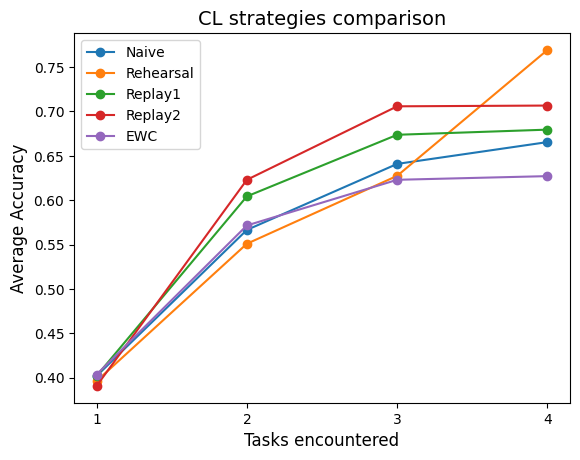

In [128]:
plt.plot([1, 2, 3, 4], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3, 4], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3, 4], repl1_accs, '-o', label="Replay1")
plt.plot([1, 2, 3, 4], repl2_accs, '-o', label="Replay2")
plt.plot([1, 2, 3, 4], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks encountered', fontsize=12)
plt.ylabel('Average Accuracy', fontsize=12)
plt.title('CL strategies comparison', fontsize=14);
plt.xticks([1, 2, 3, 4])
plt.legend(prop={'size': 10});

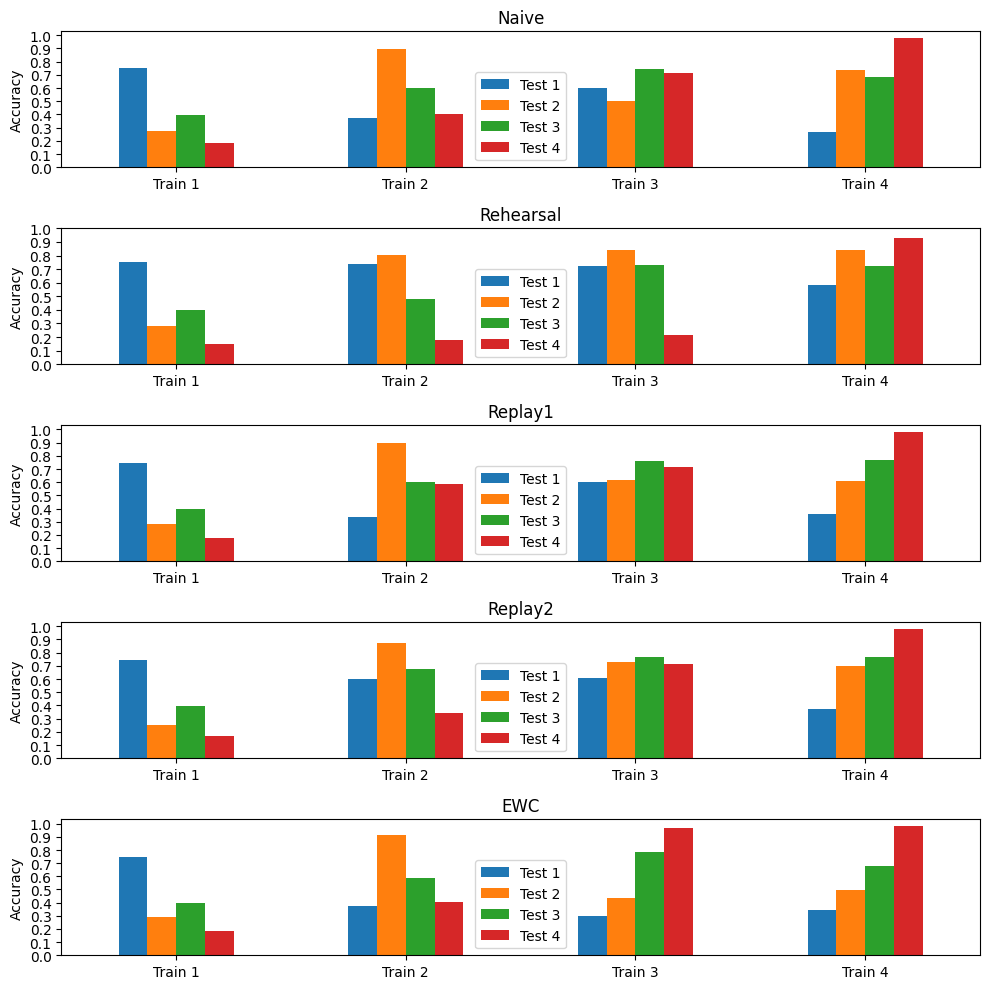

In [129]:
# All accuracy values on all strategies
fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(10,10))

for i, strategy in enumerate(accs_table):
  index = ["Train "+str(i) for i in range(1,num_experiences+1)]
  df_dict = {"Test "+str(i) : np.asarray(accs_table[strategy])[:,i-1] for i in range(1,num_experiences+1)}
  df = pd.DataFrame(df_dict, index=index)
  df.plot.bar(rot=0, ax=ax[i])
  ax[i].set_title(strategy, fontsize=12)
  ax[i].set_ylabel("Accuracy")
  ax[i].set_yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()

All the models described exhibit **plasticity**, allowing for continuous learning on new experiences.

Looking at the plots, they demonstrate a form of **forward transfer** behavior by enhancing performance in subsequent experiences with each training. However, we can observe this only in the second and third training. To get a deeper understanding of this behavior, it's important to analyze also the forward transfer metric, since it provides insights into the model's behavior both after the initial training and after the final one.

Out of all the models, *Rehearsal* stands out by maintaining the highest accuracy on experiences throughout the entire training duration. However, it's important to note that it still hasn't completely eliminated the issue of *catastrophic forgetting*.

## A metric

In [130]:
a_metric = {}
for strategy in accs_table:
  a_metric[strategy] = 0
  for i in range(0,num_experiences):
    for j in range(0,i+1):
      a_metric[strategy] += accs_table[strategy][i][j]
  a_metric[strategy] /= (num_experiences * (num_experiences + 1) / 2)
a_metric

{'Naive': 0.6524804472923279,
 'Rehearsal': 0.7673652768135071,
 'Replay1': 0.6676419615745545,
 'Replay2': 0.7150863021612167,
 'EWC': 0.6073167807886546}

## BWT metric

In [131]:
bwt = {}
for strategy in accs_table:
  bwt[strategy] = 0
  for i in range(0,2):
    bwt[strategy] += (
        accs_table[strategy][num_experiences-1][i] -
        accs_table[strategy][i][i]
    )
  bwt[strategy] /= (num_experiences-1)
bwt

{'Naive': -0.21522672971089682,
 'Rehearsal': -0.045423686504364014,
 'Replay1': -0.22574382026990256,
 'Replay2': -0.17915277679761252,
 'EWC': -0.2723961260754897}

No evidence of a **backward transfer** property is observed, as it was clearly evident from the plots.

## FWT metric

In [132]:
fwt = {}
for strategy in accs_table:
  fwt[strategy] = 0
  for i in range(1,num_experiences):
    fwt[strategy] += (
        accs_table[strategy][i-1][i] -
        accs_table_random_model[strategy][i]
    )
  fwt[strategy] /= (num_experiences-1)
fwt

{'Naive': 0.09376994768778484,
 'Rehearsal': -0.07326909899711609,
 'Replay1': 0.041075040896733604,
 'Replay2': 0.057787954807281494,
 'EWC': 0.13707438363804664}

All the values are relatively small, making them subject to variation based on random predictions or specific training processes. Considering this, it's unclear whether the models exhibit a significant forward transfer behavior.

# SML and CL comparison

In [133]:
metrics = dict()
metrics['Average Accuracy'] = [ARF_avg_accuracy, ARF2_avg_accuracy, HAT_avg_accuracy, HAT2_avg_accuracy, naive_accs[-1], rehe_accs[-1], repl1_accs[-1], repl2_accs[-1], ewc_accs[-1]]
metrics['A metric'] = [ARF_a_metric, ARF2_a_metric, HAT_a_metric, HAT2_a_metric]
metrics['Forward Transfer'] = [ARF_ft_metric, ARF2_ft_metric, HAT_ft_metric, HAT2_ft_metric,]
metrics['Backward Transfer'] = [ARF_bt_metric, ARF2_bt_metric, HAT_bt_metric, HAT2_bt_metric,]

for strategy in accs_table:
  metrics['A metric'].append(a_metric[strategy])
  metrics['Forward Transfer'].append(fwt[strategy])
  metrics['Backward Transfer'].append(bwt[strategy])

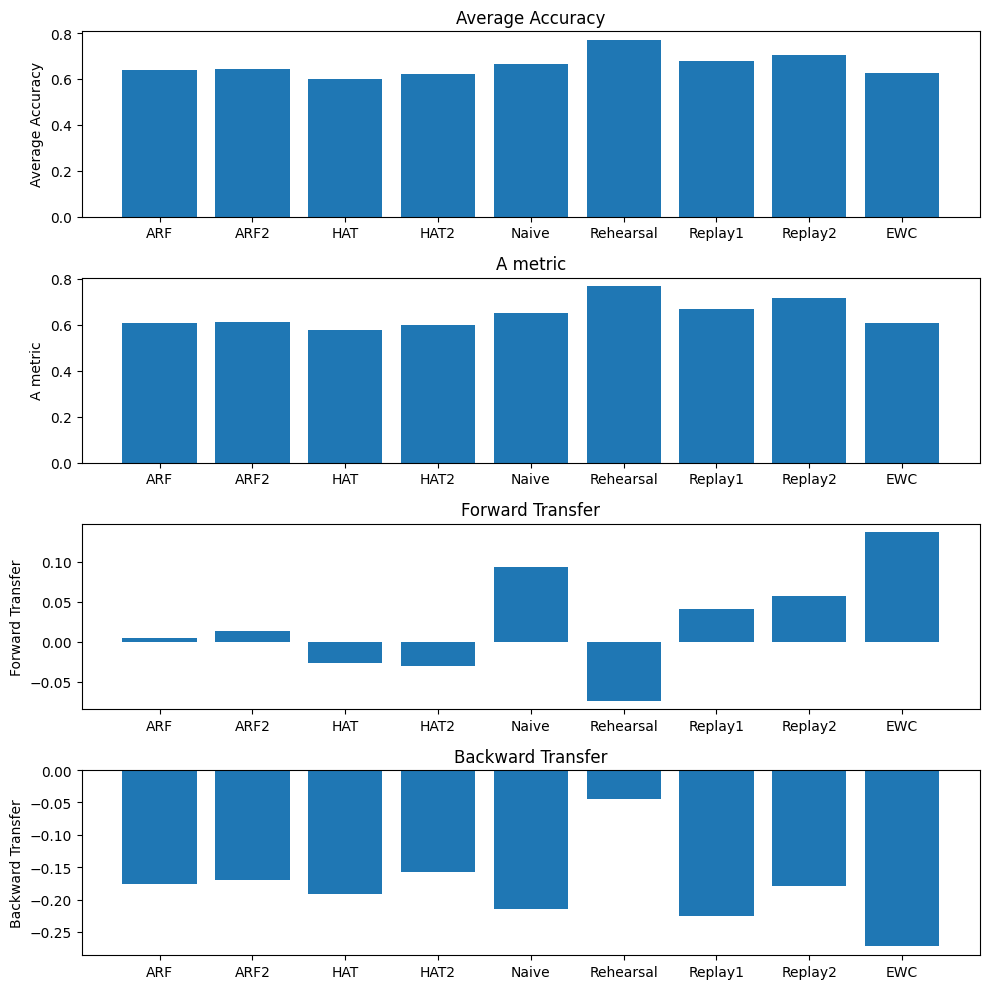

In [134]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs = axs.flatten()

for i, (metric_name, values) in enumerate(metrics.items()):
  ax = axs[i]
  x = ['ARF','ARF2','HAT','HAT2','Naive','Rehearsal','Replay1','Replay2','EWC']
  ax.bar(x, values)
  ax.set_ylabel(metric_name)
  ax.set_title(f'{metric_name}')

plt.tight_layout()
plt.show()

## Conclusions

Considering all the calculated metric values, no particular differences are evident between the SML models and the implemented CL strategies. It is important to highlight that all experiments demonstrated the models' ability to adapt to new tasks. However, it was expected that CL strategies would be more effective in mitigating the catastrophic forgetting phenomenon, given that they were designed for this purpose. The values of backward transfer, however, tell a different story.

In my analysis, one issue may be the initial models' inability to achieve significant accuracy values during the first trainings. Since the problem at hand involves simple binary classification, surpassing a random accuracy of approximately 1/2 (equivalent to a coin toss) can be challenging. Consequently, accuracy values between 60% and 70% are not to be considered highly significant. Furthermore, when examining all the forward transfer values, this struggle to outperform random model performances is evident, even when the plots illustrate a forward transfer behavior.

The aforementioned issue could arise from the existence of data that aren't particularly useful for resolving the classification. Alternatively, it could be attributed to an incorrect choice of the base model. A more suitable base model might have required better hyperparameter tuning to achieve improved performance during the initial training.

In conclusion, it is certainly necessary to explore more complex strategies and perhaps preprocess the initial dataset more carefully to attain meaningful performance improvements on basic models.